### Configuration

In [1]:
import os
import numpy as np
import pandas as pd

import mne
import yasa

import utils__config

In [2]:
os.chdir(utils__config.working_directory)
os.getcwd()

'g:\\My Drive\\Residency\\Research\\Lab - Damisah\\Project - Sleep'

### Parameters

In [3]:
fif_path = 'Cache/Subject01/S01_Feb02_256hz.fif'
hypno_path = 'Cache/Subject01/S01_hypnogram.csv'
potato_path = 'Cache/Subject01/S01_potatogram.csv'

# fif_path = 'Cache/Subject02/Apr26/S02_Apr26_256hz.fif'
# hypno_path = 'Cache/Subject02/Apr26/S02_Apr26_hypnogram.csv'
# potato_path = 'Cache/Subject02/Apr26/S02_Apr26_potatogram.csv'

# fif_path = 'Cache/Subject02/Apr27/S02_Apr27_256hz.fif'
# hypno_path = 'Cache/Subject02/Apr27/S02_Apr27_hypnogram.csv'
# potato_path = 'Cache/Subject02/Apr27/S02_Apr27_potatogram.csv'

In [5]:
sampling_freq = 256

### Sleep Staging

Validated on scalp EEG with 85% accuracy against expert consensus: https://doi.org/10.7554/eLife.70092

C:\Users\Layton\AppData\Local\Temp\ipykernel_12588\3470375778.py:1: RuntimeWarning: This filename (Cache/Subject01/S01_Feb02_256hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = False)
c:\Users\Layton\miniconda3\envs\sandbox\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
02-Apr-23 22:29:23 | WARNING | Hypnogram is SHORTER than data by 1.46 seconds. Padding hypnogram with last value to match data.size.


N2    125
W      80
R      17
N1     14
N3      4
Name: sleep_stage, dtype: int64
{'TIB': 120.0, 'SPT': 96.0, 'WASO': 16.0, 'TST': 80.0, 'N1': 7.0, 'N2': 62.5, 'N3': 2.0, 'REM': 8.5, 'NREM': 71.5, 'SOL': 24.0, 'Lat_N1': 24.0, 'Lat_N2': 34.0, 'Lat_N3': 82.5, 'Lat_REM': 66.0, '%N1': 8.75, '%N2': 78.125, '%N3': 2.5, '%REM': 10.625, '%NREM': 89.375, 'SE': 66.66666666666667, 'SME': 83.33333333333333}


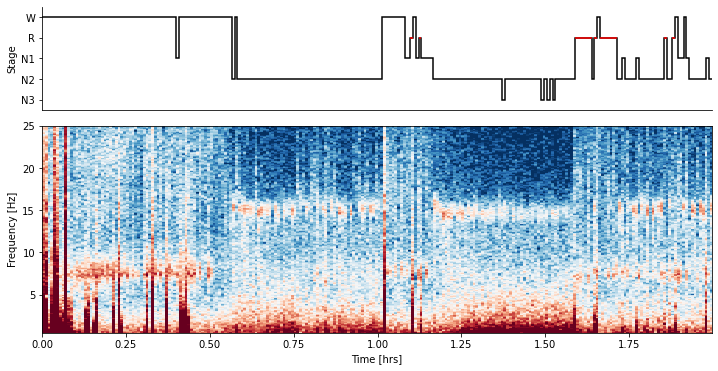

In [6]:
raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = False)

sls = yasa.SleepStaging(raw, 
                        eeg_name = 'C4', # required EEG channel, preferably central (C4 - M1)
                        eog_name = None, #'LOC', # optional EOG channel, preferably left LOC
                        emg_name = None # optional EMG channel, preferably chin
                        )

hypnogram = sls.predict()

# Print the results of automated sleep staging
print(pd.DataFrame(hypnogram, columns = ['sleep_stage'])['sleep_stage'].value_counts())

# Recode string hypnogram to integer hypnogram
hypnogram = yasa.hypno_str_to_int(hypno = hypnogram)

# Calculate sleep statistics
sleep_stats = yasa.sleep_statistics(hypno = hypnogram, sf_hyp = (1/30))
print(sleep_stats)

# Upsample hypnogram (30s resolution) for compatibility
hypnogram = yasa.hypno_upsample_to_data(hypno = hypnogram,
                                        sf_hypno = (1/30),
                                        data = raw)

# Pick central electrode and plot
spectro_data = raw.copy().pick_channels(['C4']).get_data()[0]

fig = yasa.plot_spectrogram(data = spectro_data, 
                            sf = sampling_freq, 
                            hypno = hypnogram)

In [7]:
# Export hypnogram
# (hypnograms need to be 1D numpy arrays, so save it this way)
np.savetxt(hypno_path, hypnogram, delimiter = ",")

### Artifact Rejection (Riemann Potato)

In [ ]:
boolean_artifacts, _ = yasa.art_detect(data = raw,
                                       sf = sampling_freq, 
                                       window = 5, # Window length of artifact evaluative epochs in seconds
                                       hypno = hypnogram, # this needs to be an upsampled hypnogram
                                       include = (1, 2, 3, 4), # Sleep stages to analyze
                                       method = 'covar', # Riemannian Potato algorithm
                                       threshold = 3, # Number of SD's for rejection
                                       verbose = 'info')

# Upsample artifact hypnogram (5s resolution) for compatibility
boolean_artifacts = yasa.hypno_upsample_to_data(hypno = boolean_artifacts,
                                                sf_hypno = (1/5),
                                                data = raw)

# Add -1 to hypnogram where artifacts were detected
processed_hypnogram = hypnogram.copy()
processed_hypnogram[boolean_artifacts] = -1

fig2 = yasa.plot_spectrogram(data = spectro_data, 
                             sf = sampling_freq, 
                             hypno = processed_hypnogram)

In [ ]:
# Export hypnogram with annotated artifacts
# (hypnograms need to be 1D numpy arrays, so save it this way)
np.savetxt(potato_path, processed_hypnogram, delimiter = ",")